#### Covid-19 Severity assessment classification using CNN_SVM
###### CNN for the feature extraction. i.e outliers,infected regions, resoultions etc.
###### SVM: It is used for the classification of the images.



In [3]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
import itertools

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, concatenate, Input, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, Adadelta
from keras.layers.advanced_activations import LeakyReLU
from keras.utils.np_utils import to_categorical

#### Load Data

In [118]:
train_dir = '/kaggle/input/covid-severity-assessment/dataset/train'
test_dir = '/kaggle/input/covid-severity-assessment/dataset/test'
test_data=pd.read_csv('/kaggle/input/covid-severity-assessment/dataset/test_data.csv')


#### Different Species

In [5]:
Images = ['Mild','Normal','Severe']

for images in Images:
    print('{} {} images'.format(images, len(os.listdir(os.path.join(train_dir, images)))))
    

Mild 1291 images
Normal 653 images
Severe 1064 images


#### Training Data Files

In [6]:
train = []
##species_num=img_num
##SPECIES=Images

for img_num, images in enumerate(Images):
    for file in os.listdir(os.path.join(train_dir, images)):
        train.append(['/kaggle/input/covid-severity-assessment/dataset/train/{}/{}'.format(images, file), img_num, images])
        
train = pd.DataFrame(train, columns=['file', 'img_num', 'Images'])

print('Training Data: ',train.shape)


Training Data:  (3008, 3)


In [56]:
train['file'][0]

'/kaggle/input/covid-severity-assessment/dataset/train/Mild/Mild_668.png'

#### Loading Traing Data

In [8]:
%%time

x_train = []

for i in range(len(train)):
    img = cv2.imread(train['file'][i])
    img = cv2.resize(img,dsize=(256,256))
    img = cv2.cvtColor( img, cv2.COLOR_RGB2GRAY )
    img = np.reshape(img,(256,256,1))
    x_train.append(np.concatenate((np.array(img),np.array(img)),axis=2))

x_train = np.array(x_train)


CPU times: user 3.89 s, sys: 743 ms, total: 4.63 s
Wall time: 15.6 s


#### Sample Images

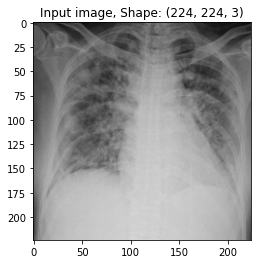

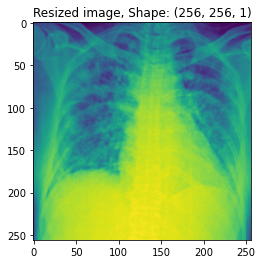

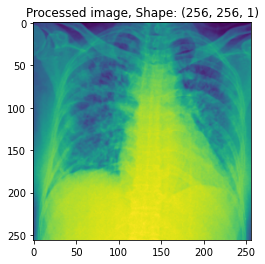

In [9]:
# Input image
Input_image = cv2.imread(train['file'][len(train)-1])

plt.imshow(Input_image)
plt.title('Input image, Shape: '+str(Input_image.shape))
plt.show()

# Resized image
plt.imshow(img)
plt.title('Resized image, Shape: '+str(img.shape))
plt.show()
        
#processed image
plt.imshow(np.reshape(img,(256,256)))
plt.title('Processed image, Shape: '+str(img.shape))
plt.show()


#### One-hot Encoding

In [10]:
labels = train['img_num']
labels = to_categorical(labels, num_classes = len(Images))


#### CV-Partition

In [11]:
x_train, x_val, y_train, y_val = train_test_split(x_train, labels, test_size = 0.1, random_state=10)


#### Input Shape

In [12]:
input_shape = x_train[1].shape
print('Input Shape is :', input_shape)


Input Shape is : (256, 256, 2)


## <span style="color:teal">Architecture</span>
---

In [13]:
def fire_incept(x, fire=16, intercept=64):
    x = Conv2D(fire, (5,5), strides=(2,2))(x)
    x = LeakyReLU(alpha=0.15)(x)
    
    left = Conv2D(intercept, (3,3), padding='same')(x)
    left = LeakyReLU(alpha=0.15)(left)
    
    right = Conv2D(intercept, (5,5), padding='same')(x)
    right = LeakyReLU(alpha=0.15)(right)
    
    x = concatenate([left, right], axis=3)
    return x

def fire_squeeze(x, fire=16, intercept=64):
    x = Conv2D(fire, (1,1))(x)
    x = LeakyReLU(alpha=0.15)(x)
    
    left = Conv2D(intercept, (1,1))(x)
    left = LeakyReLU(alpha=0.15)(left)
    
    right = Conv2D(intercept, (3,3), padding='same')(x)
    right = LeakyReLU(alpha=0.15)(right)
    
    x = concatenate([left, right], axis=3)
    return x

image_input=Input(shape=input_shape)

x = fire_incept((image_input), fire=16, intercept=16)

x = fire_incept(x, fire=32, intercept=32)
x = fire_squeeze(x, fire=32, intercept=32)

x = fire_incept(x, fire=64, intercept=64)
x = fire_squeeze(x, fire=64, intercept=64)

x = fire_incept(x, fire=64, intercept=64)
x = fire_squeeze(x, fire=64, intercept=64)

x = Conv2D(64, (3,3))(x)
x = LeakyReLU(alpha=0.1)(x)

x = Flatten()(x)

x = Dense(512)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.1)(x)

out = Dense(len(Images), activation='softmax')(x)

model_new = Model(image_input, out)
model_new.summary()


2023-01-25 15:32:08.090675: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 15:32:08.190081: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 15:32:08.190882: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 15:32:08.192567: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 2) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 126, 126, 16) 816         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 126, 126, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 126, 126, 16) 2320        leaky_re_lu[0][0]                
______________________________________________________________________________________________

#### Compile the model

In [14]:
model_new.compile(optimizer = Adam(lr=.00025) , loss = 'categorical_crossentropy', metrics=['accuracy'])


#### Set a learning rate annealer

In [16]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, 
                                            factor=0.5, min_lr=0.00001)


#### Data Augumentation

In [17]:
datagen = ImageDataGenerator(rotation_range=40, zoom_range = 0.2, width_shift_range=0.2, height_shift_range=0.2,
                             horizontal_flip=True, vertical_flip=True)
datagen.fit(x_train)


### <span style="color:teal">Fit the model</span>

In [18]:
batch_size = 32
epochs = 120


### Train the model

In [19]:
# Training
history = model_new.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size), epochs = epochs,
                                  validation_data = (x_val,y_val), verbose = 1, 
                                  steps_per_epoch=x_train.shape[0] // batch_size, 
                                  callbacks=[learning_rate_reduction])

2023-01-25 15:33:22.207638: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/120


2023-01-25 15:33:24.607815: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


84/84 [==============================] - 34s 306ms/step - loss: 1.1119 - accuracy: 0.4022 - val_loss: 1.0362 - val_accuracy: 0.4850
Epoch 2/120
84/84 [==============================] - 26s 308ms/step - loss: 1.0749 - accuracy: 0.4236 - val_loss: 1.0783 - val_accuracy: 0.4850
Epoch 3/120
84/84 [==============================] - 26s 308ms/step - loss: 1.0701 - accuracy: 0.4239 - val_loss: 1.0450 - val_accuracy: 0.4850
Epoch 4/120
84/84 [==============================] - 25s 293ms/step - loss: 1.0710 - accuracy: 0.4236 - val_loss: 1.0467 - val_accuracy: 0.4850
Epoch 5/120
84/84 [==============================] - 25s 298ms/step - loss: 1.0644 - accuracy: 0.4217 - val_loss: 1.0489 - val_accuracy: 0.4850
Epoch 6/120
84/84 [==============================] - 25s 299ms/step - loss: 1.0686 - accuracy: 0.4232 - val_loss: 1.0286 - val_accuracy: 0.4850
Epoch 7/120
84/84 [==============================] - 26s 304ms/step - loss: 1.0606 - accuracy: 0.4262 - val_loss: 1.0506 - val_accuracy: 0.4850
Epoc

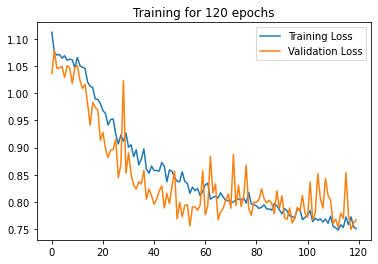

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training for ' +str(epochs)+ ' epochs')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()


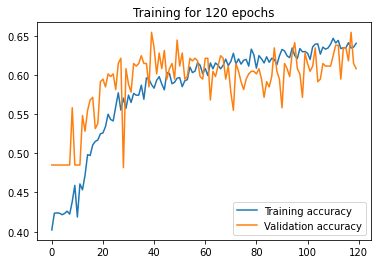

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training for ' +str(epochs)+ ' epochs')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
plt.show()


### <span style="color:teal">Predictions</span>
***

In [102]:
%%time

test = []
for file in os.listdir(os.path.join(test_dir)):
    test.append(['/kaggle/input/covid-severity-assessment/dataset/test/{}'.format(file)])

# x='/kaggle/input/covid-severity-assessment/dataset/test/Mild_14.png'
# img=cv2.imread('/kaggle/input/covid-severity-assessment/dataset/test/Mild_14.png')
# plt.imshow(img)
test = pd.DataFrame(test, columns=['file'])
print(test.head(5))



x_test = []

for i in range(len(test)):
    img = cv2.imread(test['file'][i])
    img = cv2.resize(img,dsize=(256,256))
    img = cv2.cvtColor( img, cv2.COLOR_RGB2GRAY )
    img = np.reshape(img,(256,256,1))
    x_test.append(np.concatenate((np.array(img),np.array(img)),axis=2))

x_test = np.array(x_test)


                                                file
0  /kaggle/input/covid-severity-assessment/datase...
1  /kaggle/input/covid-severity-assessment/datase...
2  /kaggle/input/covid-severity-assessment/datase...
3  /kaggle/input/covid-severity-assessment/datase...
4  /kaggle/input/covid-severity-assessment/datase...
CPU times: user 60.4 ms, sys: 8.03 ms, total: 68.5 ms
Wall time: 114 ms


#### Sample Test images

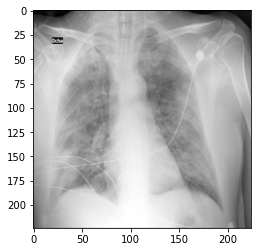

In [180]:
randm = np.random.randint(0,len(test))

img = cv2.imread(test['file'][randm])
plt.imshow(img)
plt.show()

# img_processed = x_test[randm]
# plt.imshow(img_processed)
# plt.show()

#### Prediction Score on validation set.

In [104]:
score = model_new.evaluate(x_val,y_val)
print('Accuracy on Validation Set',score[1])

10/10 [==============================] - 0s 16ms/step - loss: 0.7672 - accuracy: 0.6080
Accuracy on Validation Set 0.6079733967781067


#### Prediction on Test Set

In [106]:
Pred_labels = np.argmax(model_new.predict(x_test),axis = 1)


## preparing csv files for the test data and adding a prediction columns.

In [195]:
Pred_labels = pd.DataFrame(Pred_labels,index =None,columns=['img_num'])

test_id = []
for file in os.listdir(test_dir):
    test_id.append(['{}'.format(file)])

test_id = pd.DataFrame(test_id, columns=['file'])

test_df = pd.DataFrame()
test_df['img_num'] = Pred_labels['img_num']
test_df['file'] = test_id['file']
test_df['images'] = [Images[i] for i in Pred_labels['img_num']]

##Merge the result with the test_data.
result = pd.merge(left=test_data, right=test_df[['file', 'images']], on="file", how="right")
##Dropping unncecssary columns.
result.drop(result.iloc[:,0:1],axis=1,inplace=True)
result.columns = ['chest-x-ray_images','actual','predicted'] 
result.to_csv('feature_extracted_CNN_result.csv', index=False)
result.head(15)



,chest-x-ray_images,actual,predicted
0,Mild_14.png,Mild,Severe
1,Normal_13.png,Normal,Mild
2,Mild_13.png,Mild,Mild
3,Severe_119.png,Severe,Severe
4,Normal_19.png,Normal,Mild
5,Mild_17.png,Mild,Mild
6,Mild_15.png,Mild,Mild
7,Mild_18.png,Mild,Mild
8,Severe_116.png,Severe,Severe
9,Severe_109.png,Severe,Severe


In [186]:
feature_extracted_CNN_result=pd.read_csv('feature_extracted_CNN_result.csv');
feature_extracted_CNN_result.head(15)

,chest-x-ray_images,actual,predicted
0,Mild_14.png,Mild,Severe
1,Normal_13.png,Normal,Mild
2,Mild_13.png,Mild,Mild
3,Severe_119.png,Severe,Severe
4,Normal_19.png,Normal,Mild
5,Mild_17.png,Mild,Mild
6,Mild_15.png,Mild,Mild
7,Mild_18.png,Mild,Mild
8,Severe_116.png,Severe,Severe
9,Severe_109.png,Severe,Severe


***
## SVM: Applying support vector machine after feature extraction.
***

#### Extracting Features from last Layer

In [158]:
model_feat = Model(inputs=model_new.input,outputs=model_new.get_layer('dense_1').output)

feat_train = model_feat.predict(x_train)
print(feat_train.shape)

feat_val = model_feat.predict(x_val)
print(feat_val.shape)

feat_test = model_feat.predict(x_test)
print(feat_test.shape)


(2707, 3)
(301, 3)
(46, 3)


#### Applying SVM Classifier.

In [196]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf')

svm.fit(feat_train,np.argmax(y_train,axis=1))

print('Data is being fitted')

Data is being fitted


#### Prediction Score [Training Features]

In [160]:
svm.score(feat_train,np.argmax(y_train,axis=1))


0.6763945326930181

#### Prediction Score [Validation Features]

In [161]:
svm.score(feat_val,np.argmax(y_val,axis=1))


0.6345514950166113

#### It will predict on the features of the cnn applied above

In [162]:
Pred_labels = svm.predict(feat_test)


In [175]:
Pred_labels = pd.DataFrame(Pred_labels,index =None,columns=['img_num'])

test_df = pd.DataFrame()
test_df['img_num'] = Pred_labels['img_num']
test_df['file'] = test_id['file']
test_df['images'] = [Images[i] for i in Pred_labels['img_num']]

result = pd.merge(left=test_data, right=test_df[['file', 'images']], on="file", how="right")
##Dropping un_necessary files from the merge result
result.drop(result.iloc[:,0:1],axis=1,inplace=True)
result.columns = ['chest-x-ray_images','actual','predicted']
print('After applying CNN+SVM\n')
print(result.head(15))

result.to_csv('result_svm_linear.csv', index=False)


After applying CNN+SVM

   chest-x-ray_images  actual predicted
0         Mild_14.png    Mild    Severe
1       Normal_13.png  Normal      Mild
2         Mild_13.png    Mild      Mild
3      Severe_119.png  Severe    Severe
4       Normal_19.png  Normal      Mild
5         Mild_17.png    Mild      Mild
6         Mild_15.png    Mild      Mild
7         Mild_18.png    Mild      Mild
8      Severe_116.png  Severe    Severe
9      Severe_109.png  Severe    Severe
10      Normal_18.png  Normal    Severe
11        Mild_25.png    Mild    Severe
12      Normal_22.png  Normal      Mild
13      Normal_16.png  Normal      Mild
14     Severe_121.png  Severe    Severe


In [177]:
df=pd.read_csv('result_svm_linear.csv')
df.head(15)

,chest-x-ray_images,actual,predicted
0,Mild_14.png,Mild,Severe
1,Normal_13.png,Normal,Mild
2,Mild_13.png,Mild,Mild
3,Severe_119.png,Severe,Severe
4,Normal_19.png,Normal,Mild
5,Mild_17.png,Mild,Mild
6,Mild_15.png,Mild,Mild
7,Mild_18.png,Mild,Mild
8,Severe_116.png,Severe,Severe
9,Severe_109.png,Severe,Severe


In [208]:
from sklearn import datasets
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm=confusion_matrix(df['actual'],df['predicted'])

In [206]:
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['Mild','Normal','Severe'], 
                     columns = ['Mild','Normal','Severe'])

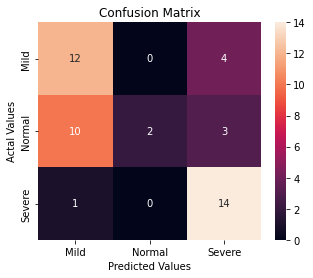

In [209]:
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()
